In [1]:
%load_ext autoreload
%load_ext line_profiler

In [2]:
#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2 

In [3]:
import functools
from time import perf_counter
import kooplearn
import numpy as np
import matplotlib.pyplot as plt
import pnstyler.styler as styler
import ml_confs

In [183]:
configs = ml_confs.from_dict({
    'train_samples': 3000,
    'test_samples': 100,
})

In [184]:
# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

## Data Generation

In [185]:
from kooplearn.datasets import Lorenz63, LogisticMap

raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs.train_samples + 1000 + configs.test_samples)
#raw_data = LogisticMap(N=20).sample(X0 = np.ones(1), T=configs.train_samples + 1000 + configs.test_samples)
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm

train_data = data[:configs.train_samples + 1]
test_data =  data[-configs.test_samples - 1:]

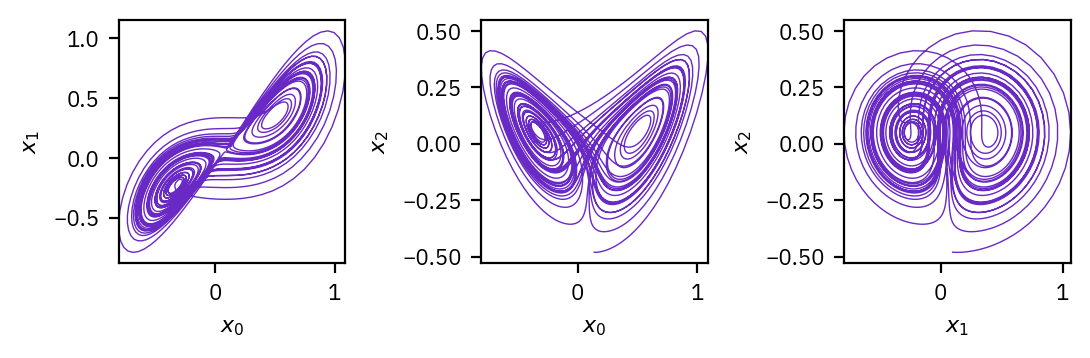

In [186]:
from itertools import combinations
fig, ax = plt.subplots(ncols=train_data.shape[1], figsize = styler.figsize(width_to_height=3), layout='tight')
for i, (x, y) in enumerate(combinations(range(train_data.shape[1]), 2)):
    ax[i].plot(data[:, x], data[:, y], lw=0.5)
    ax[i].set_xlabel(f'$x_{x}$')
    ax[i].set_ylabel(f'$x_{y}$')

## Estimator fitting

In [187]:
from sklearn.gaussian_process.kernels import RBF
from scipy.spatial.distance import pdist
from kooplearn.models import KernelDMD
from kooplearn.models.nystroem_kernel import NystroemKernelLeastSquares
from kooplearn.data import traj_to_contexts

# Length scale of the kernel: median of the pairwise distances of the dataset
data_pdist = pdist(train_data)
kernel = RBF(length_scale=np.quantile(data_pdist, 0.5))
train_contexts = traj_to_contexts(train_data)
test_contexts = traj_to_contexts(test_data)

In [188]:
reduced_rank = True
rank = 6
num_centers = 500
tikhonov_reg = 1e-6

models = {
    'KernelDMD': KernelDMD(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
    #'KernelDMD_full': KernelDMD(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='full'),
    'RandSVDKernelDMD': KernelDMD(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=5),
    'Nystroem': NystroemKernelLeastSquares(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
}

In [189]:
def runner(models):
    results = {}
    for name, model in models.items():
        print(f'Running {name}')
        model, fit_time = timer(model.fit)(train_contexts, verbose=False)
        # One-step prediction
        X_pred = model.predict(test_contexts[:, :-1, ...])
        X_true = test_contexts[:, 1, ...]
        # Eigenvalues
        eigs = model.eig()

        results[name] = {
            'model': model,
            'fit_time': fit_time,
            'train_risk': model.risk(),
            'rMSE_onestep': np.sqrt(np.mean((X_pred - X_true)**2)),
            'eigenvalues': eigs,
        }
    return results
    
def hausdorff_distance(eigs_1, eigs_2):
    dist = np.abs(eigs_1[:, None] - eigs_2[None, :])
    d1 = np.min(dist, axis=1).max()
    d2 = np.min(dist, axis=0).max()
    return max(d1, d2)
    
def compare_fits(U_ref, V_ref, U_est, V_est):
    W_ref = U_ref @ V_ref.T
    W_est = U_est @ V_est.T
    return np.linalg.norm(W_ref - W_est, ord='fro')/np.linalg.norm(W_ref, ord='fro')

In [190]:
results = runner(models)

Running KernelDMD
Running RandSVDKernelDMD
Running Nystroem


In [191]:
# Print results:
for name, res in results.items():
    model = res['model']
    _str = f'''
    {name}:
        Fit time: {res["fit_time"]:.2f}s
        Train risk: {res["train_risk"]:.4e}
        One-step rMSE: {res["rMSE_onestep"]:.4e}
        Hausdorff: {hausdorff_distance(res["eigenvalues"], results["KernelDMD"]["eigenvalues"]):.2e}
        Spectral Bias: {model._spectral_bias[:model.rank + 1]}'''
    print(_str)


    KernelDMD:
        Fit time: 1.18s
        Train risk: 3.4493e-02
        One-step rMSE: 2.1637e-02
        Hausdorff: 0.00e+00
        Spectral Bias: [0.77477598 0.43381845 0.27418584 0.20334868 0.18720541 0.15953047
 0.09704145]

    RandSVDKernelDMD:
        Fit time: 0.48s
        Train risk: 3.4718e-02
        One-step rMSE: 2.1946e-02
        Hausdorff: 9.07e-04
        Spectral Bias: [0.77476232 0.43379275 0.27415359 0.20329408 0.18714333 0.15915645
 0.09643471]

    Nystroem:
        Fit time: 1.13s
        Train risk: 9.9993e-01
        One-step rMSE: 2.5607e-01
        Hausdorff: 1.00e+00
        Spectral Bias: [0.77477598 0.43381845 0.27418584 0.20334868 0.18720541 0.15953047]
